In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rrcf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Read csv file
df_turbidity = pd.read_csv("node2_data_latest.csv")
print('The number of samples of the data ', len(df_turbidity))
df_turbidity.head()

The number of samples of the data  2658


,time,turbidity,pH
0,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
1,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
3,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
4,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


In [18]:
# Convert dataframe to array
turbidity_train= np.array(df_turbidity['turbidity'])

In [19]:
# Set tree parameters
num_trees = 40
shingle_size = 1
tree_size = 256


In [20]:
# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)


In [21]:
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(turbidity_train, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

In [22]:
%%time
# Display prediction result

for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point
        # (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among
        # all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

Wall time: 50.2 s


In [23]:
# Convert score dictionary to data frame.
turbidity_result = pd.DataFrame.from_dict(avg_codisp,'index')

In [24]:
# Merge score with data.
df_turbidity['turbidity'] = turbidity_result

In [29]:
#Try different values of threshold to get anomalies.
anomalies = df_turbidity.loc[df_turbidity['turbidity']>100] # wa 120, changed to 50
anomalies

,time,turbidity,pH
258,2020-11-10 07:32:12.367390+00:00,154.100000,7.38
277,2020-11-10 17:37:33.521978+00:00,148.362500,7.35
392,2020-11-13 21:09:37.282217+00:00,119.735335,7.39
394,2020-11-13 22:10:09.389225+00:00,102.662080,7.35
432,2020-11-14 18:14:35.219092+00:00,115.827555,7.35
433,2020-11-14 18:44:51.300974+00:00,135.165999,7.35
681,2020-11-20 07:27:40.723894+00:00,233.562054,7.36
684,2020-11-20 08:58:28.911188+00:00,116.817222,7.35
1075,2020-11-28 22:49:17.820898+00:00,251.850000,7.35
1118,2020-11-29 22:01:36.359777+00:00,231.662500,7.35


In [30]:
len(anomalies)

24

Text(0.5, 1.0, 'Turbidity data (red) and anomaly score (blue)')

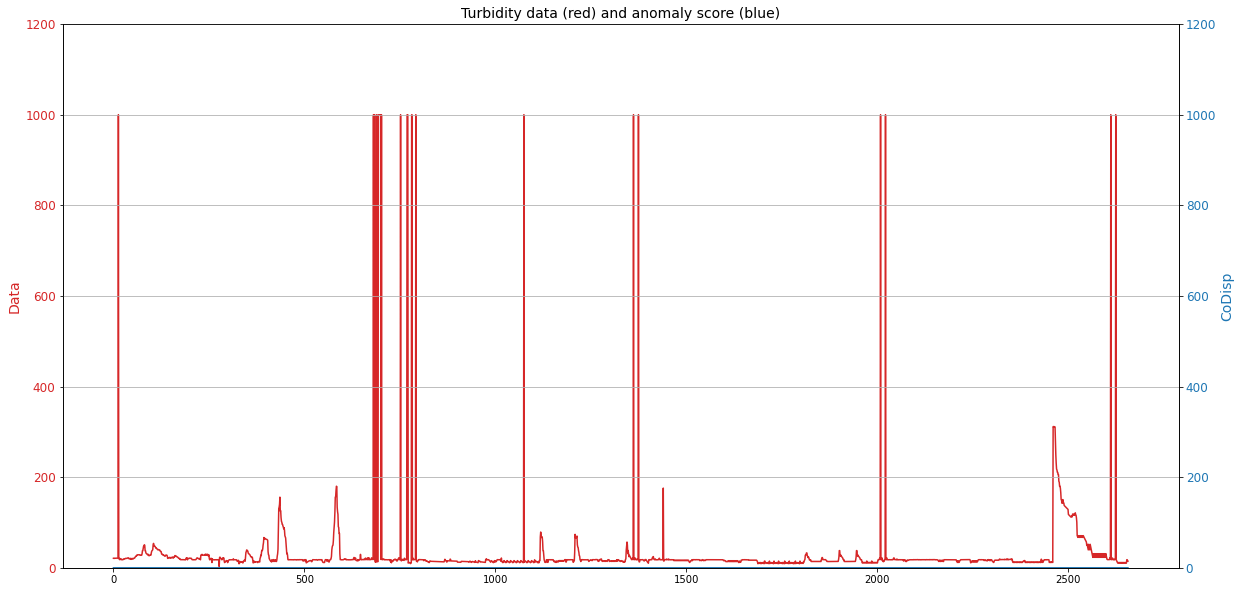

In [31]:
for index in range(len(avg_codisp)):
    avg_codisp[index]=avg_codisp[index]/50
    
fig, ax1 = plt.subplots(figsize=(20, 10))
color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=14)
ax1.plot(turbidity_train, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,1200)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0,1200)
plt.title('Turbidity data (red) and anomaly score (blue)', size=14)

Text(0.5, 1.0, 'Turbidity data (red) and anomaly score (blue)')

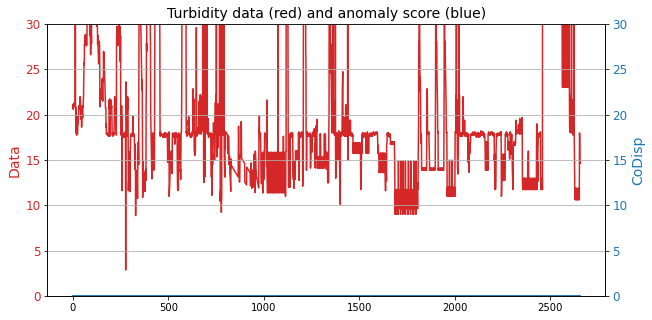

In [32]:
for index in range(len(avg_codisp)):
    avg_codisp[index]=avg_codisp[index]/50
    
fig, ax1 = plt.subplots(figsize=(10, 5))
color = 'tab:red'
ax1.set_ylabel('Data', color=color, size=14)
ax1.plot(turbidity_train, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,30)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0,30)
plt.title('Turbidity data (red) and anomaly score (blue)', size=14)

In [33]:
df_anomalies = anomalies

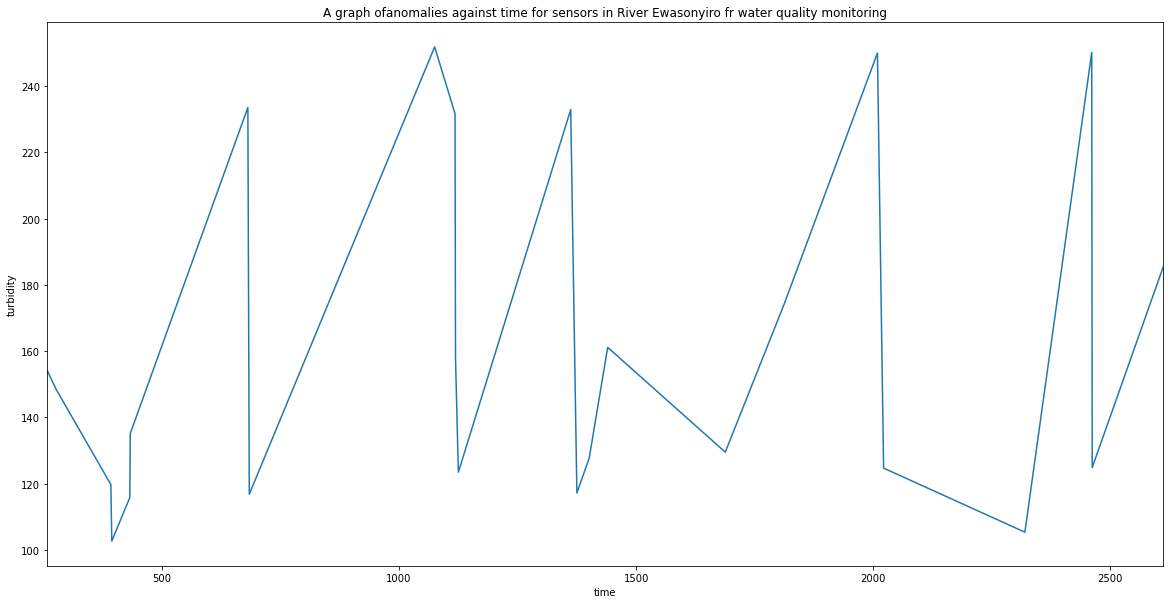

In [34]:
def plot_anomalies_data(df_anomalies, title):
    f1 = plt.figure(figsize =(20, 10))
    df_anomalies['turbidity'].plot( )
    plt.xlabel("time")
    plt.ylabel("turbidity")
    plt.title(title)
    plt.show( )
    
    
plot_anomalies_data(df_anomalies, "A graph ofanomalies against time for sensors in River Ewasonyiro fr water quality monitoring")

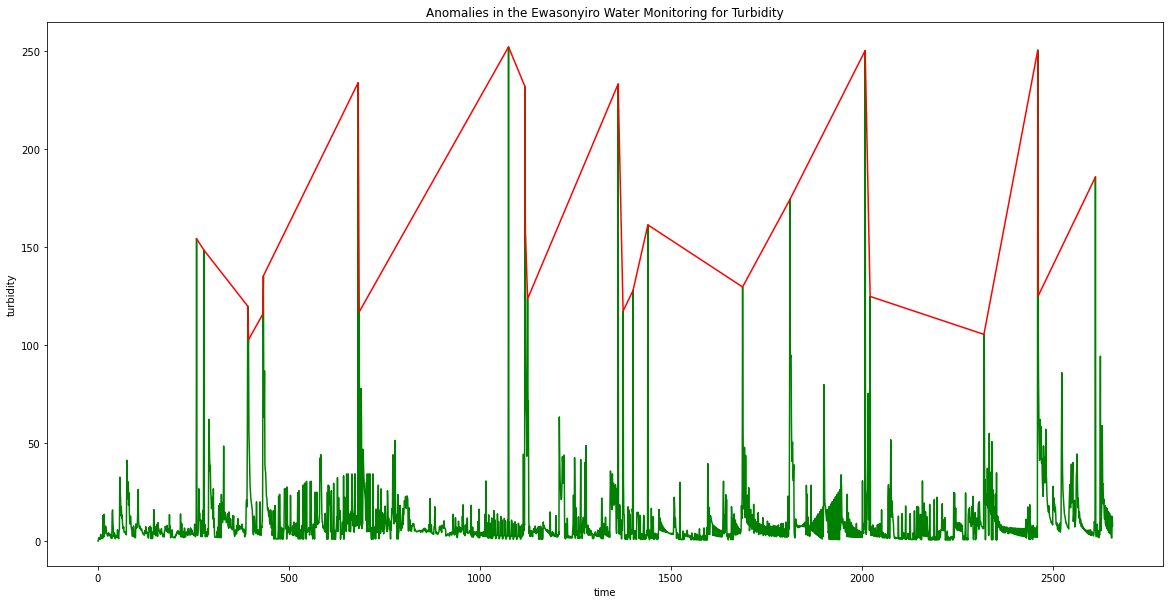

In [35]:
# lets plot the result of LOF anomaly detection
def plot_lof_result(dataset, anomalies, title):
    if 'isinlier' in dataset.columns:
        del dataset['isinlier']
        
    if 'isinlier' in anomalies.columns:
        del anomalies['isinlier']
        
    f2 = plt.figure(figsize =(20, 10))
    plt.plot(dataset['turbidity'], color='green')
    plt.plot(anomalies['turbidity'], "r", markersize =10)
    plt.xlabel("time")
    plt.ylabel("turbidity")
    plt.title(title)
    plt.show()
    
    
plot_lof_result(df_turbidity, df_anomalies , "Anomalies in the Ewasonyiro Water Monitoring for Turbidity")
